In [1]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load, Parallel, delayed
import os
import copy
import datetime as dt
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from plotnine import *
from scipy import stats


# Import ML models
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from dddex.levelSetKDEx_univariate import LevelSetKDEx, LevelSetKDEx_NN
from dddex.wSAA import RandomForestWSAA, SampleAverageApproximation

# Weights & Biases
import wandb

# Import Gurobi
import gurobipy as gp
from gurobipy import GRB

# Optimization Module
from DataDrivenPatientScheduling import WeightsModel
from DataDrivenPatientScheduling import Experiment

In [2]:
# Setup directories and model names
directories_setup = dict(

    # Paths
    path_data = '/home/fesc/dddex/PatientScheduling/Data',
    path_models = '/home/fesc/dddex/PatientScheduling/Data/Models',
    path_results = '/home/fesc/dddex/PatientScheduling/Data/Results',
    
    # Models
    models = dict(
        LSx_LGBM = 'LSx_LGBM',
        LSx_NN_LGBM = 'LSx_NN_LGBM',
        wSAA_RF = 'wSAA_RF',
        SAA = 'SAA'
    )
)

# Make all experiment variables visible locally
locals().update(directories_setup)

In [3]:
# Setup the experiment
optimization_params = dict(

    # Cost params
    cost_params = [

        {'CR': 0.10, 'c_waiting_time': 1, 'c_overtime': 9},
        {'CR': 0.25, 'c_waiting_time': 1, 'c_overtime': 3},
        {'CR': 0.50, 'c_waiting_time': 1, 'c_overtime': 1},
        {'CR': 0.75, 'c_waiting_time': 3, 'c_overtime': 1},
        {'CR': 0.90, 'c_waiting_time': 9, 'c_overtime': 1}

    ],

    # Number of scenarios
    K = [10**1, 10**2, 10**3, 10**4],

    # Time budget multiplier
    rho = [0.85, 1, 1.15]

)

# Make all experiment variables visible locally
locals().update(optimization_params)

# Pre-processing

In [4]:
# Load and combine all data
results = pd.DataFrame()
for K_ in K:
    for rho_ in rho:
        for model in models:
            
            # Read
            result = pd.read_csv(path_results+'/'+model+'_K'+str(K_)+'_rho'+str(rho_)+'.csv')
            result['model'] = copy.deepcopy(model)
            
            results = pd.concat([results, result])
            
# Finalize
results = results.reset_index(drop=True)

In [5]:
# Baseline
results = pd.merge(
    left = results.loc[results.model != 'SAA'],
    right = results.loc[results.model == 'SAA', 
                        ['n_scenarios', 'utilization', 'area', 'CR', 'date', 'cost', 'waiting_time', 'overtime']],
    on = ['n_scenarios', 'utilization', 'area', 'CR', 'date'],
    suffixes = ('', '_SAA')
)

In [6]:
# Cost performance 
results['pq'] = results.cost / results.cost_SAA
results.loc[results.cost == results.cost_SAA, 'pq'] = 1.0

In [42]:
def plotCoPres(data, figsize=(9,4), dotsize=2, display=0.95, **kwargs):

    if len(data.model.unique()) > 5:
        print('Max number of models exceeded (limited to 5 models)')
        return None
    
    # Model colors
    colors = ['blue', 'black', 'red', 'green', 'yellow']
    positions = [0,1,2,3,4]
    
    # Specify limits showing at least 'upper' percent of data
    ylim_top = data.groupby(['CR', 'model']).agg(q = ('pq', lambda x: np.quantile(x, display))).reset_index().q.max()
    ylim_bottom = data.pq.min()*0.66

    # Initialize figure / sub-plots
    fig, axes = plt.subplots(ncols=len(data.CR.unique()), sharey=True)
    fig.subplots_adjust(wspace=0)

    # Create and iterate over sub-plots (per service level)
    for ax, CR in zip(axes, data.CR.unique()):

        # Volins (per model)
        vp = ax.violinplot([data.pq[(data.CR==CR) & (data.model==model)] for model in data.model.unique()], 
                           positions=[positions[i] for i in range(len(data.model.unique()))], showextrema=False)

        # Dots (per model)
        dp = sns.swarmplot(ax=ax, x='model', y='pq', hue='model', data=data.loc[data.CR==CR], 
                           size=dotsize, alpha=0.33, palette=[colors[i] for i in range(len(data.model.unique()))])
        
        # Boxplots (per model)
        bp = ax.boxplot(x=[data.pq[(data.CR==CR) & (data.model==model)] for model in data.model.unique()],
                        positions=[positions[i] for i in range(len(data.model.unique()))], 
                        medianprops={'color': 'black', 'linewidth': 2.5}, 
                        widths=0.33, showfliers=False, showcaps=False, whis=0, patch_artist=True)

        # Baseline (per model)
        ax.axhline(y=1, linewidth=1, linestyle='--', color='grey')

        # Color coding for violins and boxplots
        for i in range(len(data.model.unique())):

            # Violins
            vp['bodies'][i].set_facecolor('grey')

            # Boxplots
            bp['boxes'][i].set_color(colors[i])
            bp['boxes'][i].set_facecolor([0,0,0,0])
            #bp['whiskers'][i].set_color(colors[i])
            #bp['caps'][i].set_color(colors[i])
            bp['medians'][i].set_color(colors[i])


        # Remove x-axis ticks
        ax.tick_params(
            axis='x',          
            which='both',      
            bottom=False,      
            labelbottom=False) 

        # Set axis inner axis titles
        ax.set_xlabel(xlabel='{:.2f}'.format(CR))
        ax.set_ylabel(ylabel='normalized cost', fontsize=10, fontweight='bold')
        ax.xaxis.set_label_position('bottom')
        ax.label_outer()

        # Set limits
        ax.set_ylim(bottom=0.7, top=1.1)

        # Add margin
        ax.margins(0.05) 

        # Remove legends per sub-plot
        ax.get_legend().remove()


    # Add figure legend    
    #fig.legend(
    #    [bp['boxes'][i] for i in range(len(data.model.unique()))], 
    #    data.model.unique(), 
    #    loc=(0.444,0.79)
    #)
    
    fig.legend(
        [bp['boxes'][i] for i in range(len(data.model.unique()))], 
        data.model.unique(), 
        bbox_to_anchor=[0.5, 0.95], 
        loc='center', ncol=len(data.model.unique())
    )
    
    

    # Add figure sub-title (below)
    plt.title('Critical ratio', fontsize=10, fontweight='bold', x=-2.5, y=-0.175)

    # Set size
    fig.set_size_inches(figsize)

    # Show plot
    plt.show()

    return fig

# Cost performance

In [43]:
sel = (results.n_scenarios == 10000) & (results.utilization == 1) & (~np.isinf(results.pq)) & (results.n_patients >= 3)
plotData = results.loc[sel]

/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
/home/fesc/.conda/envs/dddex/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers

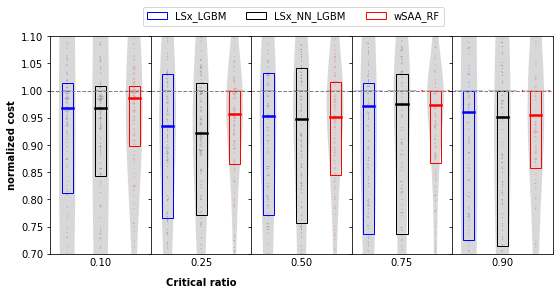

In [44]:
plot = plotCoPres(plotData, dotsize=1)

In [41]:
plotData.groupby('CR').pq.describe()

,count,mean,std,min,25%,50%,75%,max
CR,,,,,,,,
0.10,454.0,1.027084,0.881246,0.000000,0.856322,0.977538,1.011012,10.125000
0.25,459.0,0.913218,0.298442,0.000000,0.800000,0.944737,1.013923,3.166667
0.50,462.0,0.930428,0.264945,0.000000,0.800000,0.952317,1.030044,2.700000
0.75,462.0,0.924047,0.325410,0.000000,0.779004,0.972415,1.000000,5.363636
0.90,462.0,0.956996,0.777509,0.076923,0.765587,0.955921,1.000000,14.636364


In [11]:
1/(4)

0.25

In [ ]:
sum(np.isinf(plotData.pq))

# Cost over scenarios

In [ ]:
rho = 0.85
CR = 0.25
area = 'Bereich_Gastroskopie'
sel = (results.utilization == rho) & (results.CR == CR) & (results.area == area)

In [ ]:
results_ = results.loc[sel]

In [ ]:
results_.loc[results_.model=='LSx_LGBM'].groupby('n_scenarios').agg({'cost': sum})

# Cost over utilization